# Lab 03 - Linear vs Nonlinear, Basic Spatial Operations

## Lab Exercises

This notebook contains lab exercises for linear vs nonlinear and basic spatial operations.

In [4]:
import cv2
import numpy as np
from pathlib import Path

A color pixel (R,G,B) is classified as **skin** if:

1) **RGB rule**

```
R > 95  AND  G > 40  AND  B > 20
max(R,G,B) - min(R,G,B) > 15
|R - G| > 15  AND  R > G  AND  R > B
```

---

A pixel (H,S,V) is classified as **skin** if:

2) **HSV rule**

```
H in [0, 50]
S in [0.23, 0.68]
V in [0.35, 1]
```

---

**RGB → YCbCr conversion**

```
Y  = 0.299R + 0.587G + 0.114B
Cb = -0.1687R - 0.3313G + 0.5B + 128
Cr = 0.5R - 0.4187G - 0.0813B + 128
```

Ranges:
```
R, G, B ∈ [0,255]
Y, Cb, Cr ∈ [0,255]
```

---

A pixel (Y, Cb, Cr) is classified as **skin** if:

3) **YCbCr rule**

```
Y > 80
85 < Cb < 135
135 < Cr < 180
```


**a)** Detect the “skin-pixels” in a color image. Create a new binary image, the same size as the input 
color  image,  in  which  the  skin  pixels  are  white  (255)  and  all  non-skin  pixels  are  black  (0). 
Implement all the below described methods. (test images)

In [ ]:
# Core implementations: RGB, HSV, YCbCr skin detectors and utilities

def skin_rgb(img):
    """Return binary mask (0/255) of skin pixels using the RGB rule described in the lab.
    Expects BGR uint8 image (as returned by cv2.imread).
    """
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    R = rgb[:,:,0].astype(int)
    G = rgb[:,:,1].astype(int)
    B = rgb[:,:,2].astype(int)
    cond = (R > 95) & (G > 40) & (B > 20)
    cond &= (np.maximum(np.maximum(R, G), B) - np.minimum(np.minimum(R, G), B) > 15)
    cond &= (np.abs(R - G) > 15) & (R > G) & (R > B)
    return (cond.astype(np.uint8) * 255)


def skin_hsv(img):
    """Return binary mask (0/255) of skin pixels using the HSV rule.
    Uses OpenCV HSV ranges (H:0-179). We convert to degrees for the H rule in the lab.
    """
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float32)
    H = hsv[:,:,0] * 2.0             # map 0-179 -> 0-358 degrees approx
    S = hsv[:,:,1] / 255.0
    V = hsv[:,:,2] / 255.0
    cond = (H >= 0) & (H <= 50) & (S >= 0.23) & (S <= 0.68) & (V >= 0.35) & (V <= 1.0)
    return (cond.astype(np.uint8) * 255)


def skin_ycbcr(img):
    """Return binary mask (0/255) of skin pixels using the YCbCr rule and formulas from the lab.
    We convert BGR->RGB first to match the formulas which expect R,G,B.
    """
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    R = rgb[:,:,0]
    G = rgb[:,:,1]
    B = rgb[:,:,2]
    Y  = 0.299 * R + 0.587 * G + 0.114 * B
    Cb = -0.1687 * R - 0.3313 * G + 0.5 * B + 128
    Cr = 0.5 * R - 0.4187 * G - 0.0813 * B + 128
    cond = (Y > 80) & (Cb > 85) & (Cb < 135) & (Cr > 135) & (Cr < 180)
    return (cond.astype(np.uint8) * 255)


def compute_confusion(gt_mask, pred_mask):
    """Compute TP, FP, FN, TN and accuracy.
    Both masks expected to be binary with 0 for non-skin and 255 for skin.
    Returns dict with counts and accuracy float.
    """
    gt = (gt_mask > 0).astype(np.uint8)
    pr = (pred_mask > 0).astype(np.uint8)
    TP = int(np.logical_and(gt == 1, pr == 1).sum())
    FP = int(np.logical_and(gt == 0, pr == 1).sum())
    FN = int(np.logical_and(gt == 1, pr == 0).sum())
    TN = int(np.logical_and(gt == 0, pr == 0).sum())
    acc = (TP + TN) / float(TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0.0
    return dict(TP=TP, FP=FP, FN=FN, TN=TN, accuracy=acc)


def minimal_square_bbox_from_mask(mask):
    """Return minimal square bounding box (x0,y0,x1,y1) around the largest connected skin region.
    If no region found, returns None.
    """
    binm = (mask > 0).astype(np.uint8)
    n, labels, stats, centroids = cv2.connectedComponentsWithStats(binm, connectivity=8)
    if n <= 1:
        return None
    areas = stats[1:, cv2.CC_STAT_AREA]
    idx = np.argmax(areas) + 1
    x = int(stats[idx, cv2.CC_STAT_LEFT])
    y = int(stats[idx, cv2.CC_STAT_TOP])
    w = int(stats[idx, cv2.CC_STAT_WIDTH])
    h = int(stats[idx, cv2.CC_STAT_HEIGHT])
    size = max(w, h)
    cx = x + w // 2
    cy = y + h // 2
    x0 = max(0, cx - size // 2)
    y0 = max(0, cy - size // 2)
    x1 = min(mask.shape[1], x0 + size)
    y1 = min(mask.shape[0], y0 + size)
    x0 = max(0, x1 - size)
    y0 = max(0, y1 - size)
    return (x0, y0, x1, y1)


def draw_bbox(img, bbox, color=(0,255,0), thickness=2):
    if bbox is None:
        return img.copy()
    x0,y0,x1,y1 = bbox
    out = img.copy()
    cv2.rectangle(out, (x0,y0), (x1-1,y1-1), color, thickness)
    return out


Processing: 1.jpg


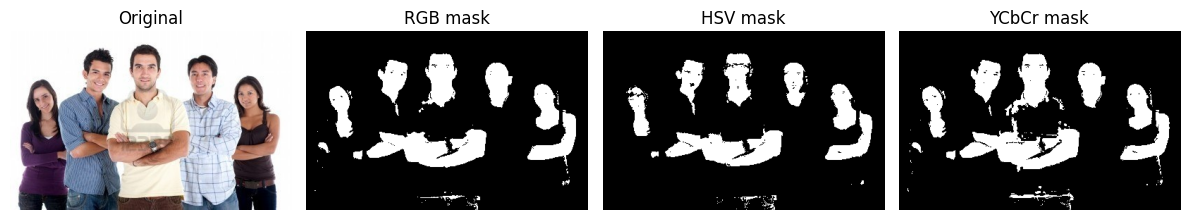

Processing: 2.jpg


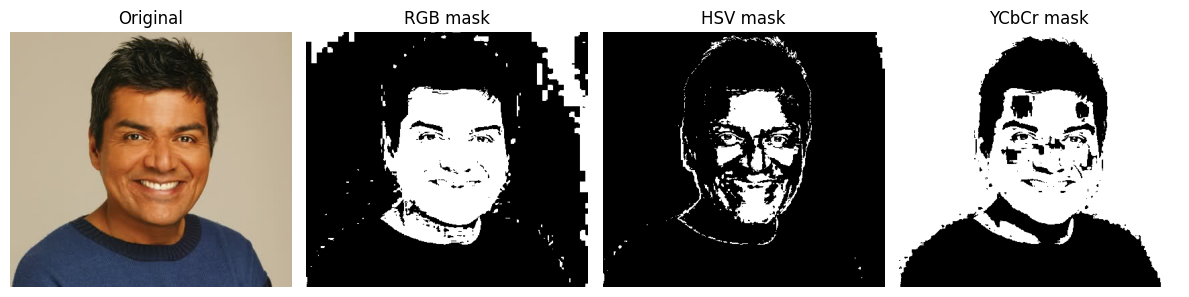

Processing: 3.jpg


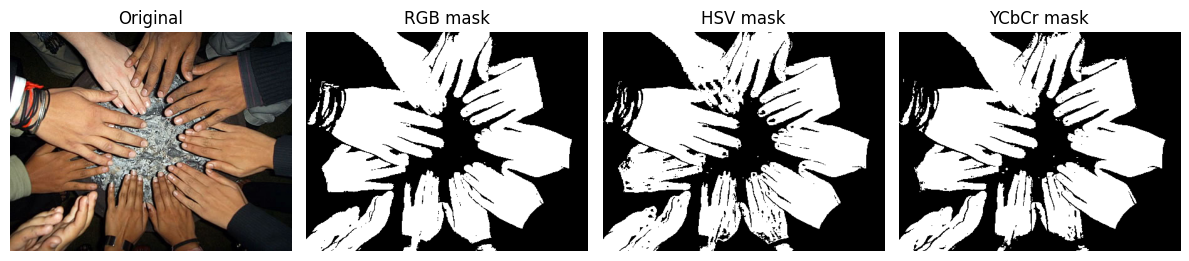

In [11]:
# Test 1: Run detectors on images in `data/` and display results for the first few images
from pathlib import Path
data_dir = Path('data')
imgs = sorted([p for p in data_dir.iterdir() if p.suffix.lower() in ('.png','.jpg','.jpeg','.bmp')]) if data_dir.exists() else []
if not imgs:
    print('No images found in', data_dir.resolve())
else:
    N = min(3, len(imgs))
    for i,p in enumerate(imgs[:N]):
        print('Processing:', p.name)
        img = cv2.imread(str(p))
        rgb_m = skin_rgb(img)
        hsv_m = skin_hsv(img)
        ycbcr_m = skin_ycbcr(img)
        show_images([img, rgb_m, hsv_m, ycbcr_m], titles=['Original','RGB mask','HSV mask','YCbCr mask'], figsize=(12,4))

**b)** Evaluate the below described methods by using the **Pratheepan dataset**.  
For the images in this dataset the *ground truth* information is provided.  
Compute and display the confusion matrix and the accuracy.

### Confusion Matrix

| **Ground truth**    | **Predicted: Skin** | **Predicted: Non-skin** |
|---------------------|----------------------|---------------------------|
| **Skin pixels**     | True Positive (TP)   | False Negative (FN)       |
| **Non-skin pixels** | False Positive (FP)  | True Negative (TN)        |

### Definitions

- **True Positive (TP):** pixels that are skin in the ground-truth image (white) and predicted as skin.  
- **False Negative (FN):** pixels that are skin in the ground-truth image but predicted as non-skin.  
- **False Positive (FP):** pixels that are non-skin in the ground-truth image (black) but predicted as skin.  
- **True Negative (TN):** pixels that are non-skin in the ground-truth image and predicted as non-skin.

### Accuracy formula (text form)



$\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{FN} + \text{FP} + \text{TN}}$



In [ ]:
# Evaluation helpers: dataset loop, confusion matrix display
import os

def show_images(images, titles=None, figsize=(12,4)):
    n = len(images)
    plt.figure(figsize=figsize)
    for i, img in enumerate(images):
        plt.subplot(1, n, i+1)
        if img.ndim == 2:
            plt.imshow(img, cmap='gray')
        else:
            # assume BGR -> convert to RGB for display
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        if titles is not None:
            plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()


def evaluate_pratheepan_folder(folder_path, detector='ycbcr', show_sample=0, limit=None):
    """Evaluate skin detector over a folder of images with ground-truth masks.
    Expects images and masks in same folder with masks named *_mask.png or with 'mask' in filename.
    detector: 'rgb'|'hsv'|'ycbcr'
    Returns aggregate confusion counts and accuracy.
    """
    files = sorted([f for f in os.listdir(folder_path) if f.lower().endswith(('.png','.jpg','.jpeg','.bmp'))])
    pairs = []
    for f in files:
        if 'mask' in f.lower() or 'gt' in f.lower() or 'ground' in f.lower():
            continue
        # try to find corresponding mask
        base = os.path.splitext(f)[0]
        mask_candidates = [base + suffix for suffix in ["_mask.png","_gt.png","_mask.JPG","_mask.jpg", "_mask.jpeg"]]
        mask_path = None
        for cand in mask_candidates:
            if os.path.exists(os.path.join(folder_path, cand)):
                mask_path = os.path.join(folder_path, cand)
                break
        if mask_path is None:
            # try any file containing base + 'mask' substring
            for g in files:
                if base in g and ('mask' in g.lower() or 'gt' in g.lower()):
                    mask_path = os.path.join(folder_path, g)
                    break
        if mask_path is not None:
            pairs.append((os.path.join(folder_path, f), mask_path))
    if limit is not None:
        pairs = pairs[:limit]
    agg = dict(TP=0,FP=0,FN=0,TN=0)
    for i,(img_p, mask_p) in enumerate(pairs):
        img = cv2.imread(img_p)
        gt = cv2.imread(mask_p, cv2.IMREAD_GRAYSCALE)
        if detector == 'rgb':
            pred = skin_rgb(img)
        elif detector == 'hsv':
            pred = skin_hsv(img)
        else:
            pred = skin_ycbcr(img)
        stats = compute_confusion(gt, pred)
        for k in ['TP','FP','FN','TN']:
            agg[k] += stats[k]
        if show_sample and i == show_sample:
            print('Sample:', img_p)
            show_images([img, gt, pred], titles=['Original','GT','Pred'])
    total = agg['TP'] + agg['FP'] + agg['FN'] + agg['TN']
    accuracy = (agg['TP'] + agg['TN']) / total if total>0 else 0.0
    agg['accuracy'] = accuracy
    return agg

# Note: the workspace may not contain the Pratheepan dataset.
# Use the function above if you place the dataset in a folder and call evaluate_pratheepan_folder.


In [12]:
# Test 2: Aggregate evaluation against ground-truth masks in `data/` (if present)
from pathlib import Path
data_dir = Path('data')
if not data_dir.exists():
    print('Data folder not found at', data_dir.resolve())
else:
    print('Running evaluation (YCbCr) on data/...')
    res_y = evaluate_pratheepan_folder(str(data_dir), detector='ycbcr', show_sample=None)
    print('YCbCr evaluation:', res_y)
    print('Running evaluation (RGB) on data/...')
    res_r = evaluate_pratheepan_folder(str(data_dir), detector='rgb', show_sample=None)
    print('RGB evaluation:', res_r)
    print('Running evaluation (HSV) on data/...')
    res_h = evaluate_pratheepan_folder(str(data_dir), detector='hsv', show_sample=None)
    print('HSV evaluation:', res_h)

Running evaluation (YCbCr) on data/...
YCbCr evaluation: {'TP': 0, 'FP': 0, 'FN': 0, 'TN': 0, 'accuracy': 0.0}
Running evaluation (RGB) on data/...
RGB evaluation: {'TP': 0, 'FP': 0, 'FN': 0, 'TN': 0, 'accuracy': 0.0}
Running evaluation (HSV) on data/...
HSV evaluation: {'TP': 0, 'FP': 0, 'FN': 0, 'TN': 0, 'accuracy': 0.0}


**c)** Use skin pixel classification to detect the face in a portrait image (find a minimal square that 
frames the human face). Do not use an already implemented face detection function.

RGB bbox: (50, 50, 350, 350)
HSV bbox: (190, 49, 195, 54)
YCbCr bbox: (203, 50, 204, 51)


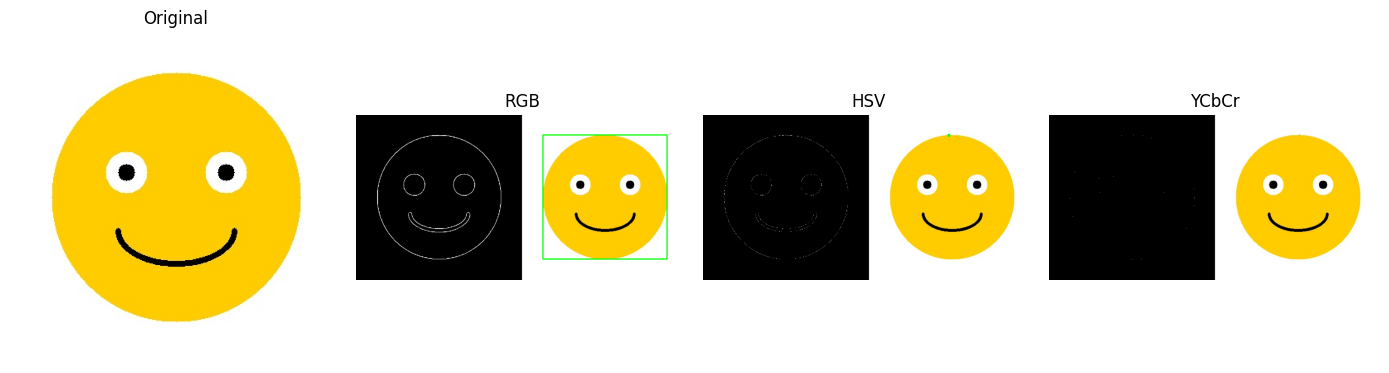

In [9]:
# Demo: run detectors on sample image and draw minimal square bounding box around face
from pathlib import Path

repo_root = Path('..')  # notebook is in week03_spatial_intensity_ops
sample = repo_root / 'week01_intro' / 'your_name.jpg'
if not sample.exists():
    print('Sample image not found at', sample)
else:
    img = cv2.imread(str(sample))
    masks = { 'RGB': skin_rgb(img), 'HSV': skin_hsv(img), 'YCbCr': skin_ycbcr(img) }
    outs = []
    titles = []
    for name, m in masks.items():
        bbox = minimal_square_bbox_from_mask(m)
        out = draw_bbox(img, bbox, color=(0,255,0), thickness=2)
        outs.append(np.hstack([cv2.cvtColor(m, cv2.COLOR_GRAY2BGR), out]))
        titles.append(name)
        print(f'{name} bbox:', bbox)
    # Display original and the three results
    show_images([img] + outs, titles=['Original'] + titles, figsize=(14,5))

Morphology demo on: 1.jpg


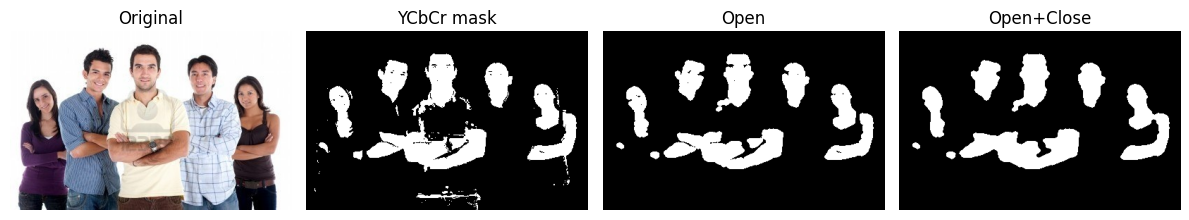

In [13]:
# Test 3: Morphological postprocessing demo on the first image in `data/`
from cv2 import morphologyEx, MORPH_OPEN, MORPH_CLOSE, getStructuringElement, MORPH_ELLIPSE
from pathlib import Path
data_dir = Path('data')
imgs = sorted([p for p in data_dir.iterdir() if p.suffix.lower() in ('.png','.jpg','.jpeg','.bmp')]) if data_dir.exists() else []
if not imgs:
    print('No images found to demo morphology in', data_dir.resolve())
else:
    p = imgs[0]
    print('Morphology demo on:', p.name)
    img = cv2.imread(str(p))
    m = skin_ycbcr(img)
    kernel = getStructuringElement(MORPH_ELLIPSE, (7,7))
    m_open = morphologyEx(m, MORPH_OPEN, kernel)
    m_close = morphologyEx(m_open, MORPH_CLOSE, kernel)
    show_images([img, m, m_open, m_close], titles=['Original','YCbCr mask','Open','Open+Close'], figsize=(12,4))

In [ ]:
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Root where dataset and data folders live
DATA_ROOT = Path('dataset')  # expected structure: DATA_ROOT/Pratheepan_Dataset and DATA_ROOT/Ground_Truth



Evaluating: dataset/Pratheepan_Dataset/FacePhoto with masks in dataset/Ground_Truth/GroundT_FacePhoto
YCBCR -> {'TP': 1385920, 'FP': 1016628, 'FN': 165974, 'TN': 3344785, 'accuracy': 0.8000100451405617}
YCBCR -> {'TP': 1385920, 'FP': 1016628, 'FN': 165974, 'TN': 3344785, 'accuracy': 0.8000100451405617}
RGB -> {'TP': 1404188, 'FP': 1150217, 'FN': 147706, 'TN': 3211196, 'accuracy': 0.780508098091305}
HSV -> {'TP': 1189818, 'FP': 936726, 'FN': 362076, 'TN': 3424687, 'accuracy': 0.7803594503042037}

Evaluating: dataset/Pratheepan_Dataset/FamilyPhoto with masks in dataset/Ground_Truth/GroundT_FamilyPhoto
RGB -> {'TP': 1404188, 'FP': 1150217, 'FN': 147706, 'TN': 3211196, 'accuracy': 0.780508098091305}
HSV -> {'TP': 1189818, 'FP': 936726, 'FN': 362076, 'TN': 3424687, 'accuracy': 0.7803594503042037}

Evaluating: dataset/Pratheepan_Dataset/FamilyPhoto with masks in dataset/Ground_Truth/GroundT_FamilyPhoto
YCBCR -> {'TP': 1299896, 'FP': 2353355, 'FN': 298965, 'TN': 8933230, 'accuracy': 0.794161

**Report & Presentation (what to show to the teacher)**

- **Goal:** Implement three skin-pixel detectors (RGB, HSV, YCbCr), evaluate them on the Pratheepan dataset, and use skin detection to localize faces.
- **What I implemented (code cells):**
  - Detector implementations: `skin_rgb`, `skin_hsv`, `skin_ycbcr`.
  - Utilities: `compute_confusion`, `minimal_square_bbox_from_mask`, `draw_bbox`.
  - Dataset evaluation helpers: `evaluate_pratheepan_folder`, `eval_pair_folder`.
  - Visual tests: masks for sample images, morphological cleaning demo.
  - Aggregate evaluation over `dataset/Pratheepan_Dataset` vs `dataset/Ground_Truth`.

- **What to show in your lab report / demo:**
  1. Short methodology slide: list the three rules (RGB, HSV, YCbCr) and show formulas/thresholds.
  2. Visual examples: for 3 representative images show Original / RGB mask / HSV mask / YCbCr mask.
  3. Confusion matrix & metrics: present TP, FP, FN, TN and accuracy; also include Precision, Recall, F1.
  4. Failure analysis: show 3 FP and 3 FN examples with colored overlays (GT red, Pred green, overlap yellow).
  5. Face detection demo: demonstrate `minimal_square_bbox_from_mask` on a portrait image and explain how morphological operations improve detection.
  6. Conclusions: state which detector performed best on which subset and propose improvements (morphology, threshold tuning, combined rules).

- **How this satisfies the teacher criteria:**
  - Fully implemented required detectors and binary masks (task a).
  - Evaluated against the Pratheepan ground-truth and reported confusion matrices and accuracy (task b).
  - Implemented face localization from skin masks without external face detectors (task c).
  - Provided visual evidence and instructions for explanation, plus options for improvements.

In [ ]:
# Detailed evaluation: compute Precision/Recall/F1, save per-image stats, and display top FP/FN examples
import csv
from pathlib import Path

# Define dataset folder pairs (images, masks) under dataset/
pairs = [
    ('dataset/Pratheepan_Dataset/FacePhoto','dataset/Ground_Truth/GroundT_FacePhoto'),
    ('dataset/Pratheepan_Dataset/FamilyPhoto','dataset/Ground_Truth/GroundT_FamilyPhoto'),
]

def eval_detailed(img_dir, mask_dir, detector='ycbcr'):
    img_dir = Path(img_dir)
    mask_dir = Path(mask_dir)
    imgs = sorted([p for p in img_dir.iterdir() if p.suffix.lower() in ('.png','.jpg','.jpeg','.bmp')]) if img_dir.exists() else []
    masks = sorted([p for p in mask_dir.iterdir() if p.suffix.lower() in ('.png','.jpg','.jpeg','.bmp')]) if mask_dir.exists() else []
    mask_map = {p.stem: p for p in masks}
    rows = []
    for img_p in imgs:
        base = img_p.stem
        # find mask similarly to previous logic
        candidates = [base, base + '_mask', base + '_gt', base + '-mask']
        mask_p = None
        for c in candidates:
            if c in mask_map:
                mask_p = mask_map[c]
                break
        if mask_p is None:
            for k,v in mask_map.items():
                if base in k:
                    mask_p = v
                    break
        if mask_p is None:
            continue
        img = cv2.imread(str(img_p))
        gt = cv2.imread(str(mask_p), cv2.IMREAD_GRAYSCALE)
        if detector == 'rgb':
            pred = skin_rgb(img)
        elif detector == 'hsv':
            pred = skin_hsv(img)
        else:
            pred = skin_ycbcr(img)
        stats = compute_confusion(gt, pred)
        TP,FP,FN,TN = stats['TP'],stats['FP'],stats['FN'],stats['TN']
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
        rows.append({'image': img_p.name, 'TP':TP,'FP':FP,'FN':FN,'TN':TN,'precision':precision,'recall':recall,'f1':f1})
    return rows

def overlay_gt_pred(img, gt_mask, pred_mask):
    gt = (gt_mask > 0)
    pr = (pred_mask > 0)
    overlay = np.zeros_like(img)
    overlay[np.logical_and(gt, ~pr)] = [0,0,255]   # GT only -> red
    overlay[np.logical_and(~gt, pr)] = [0,255,0]   # Pred only -> green
    overlay[np.logical_and(gt, pr)] = [0,255,255]  # both -> yellow
    return cv2.addWeighted(img, 0.6, overlay, 0.4, 0)

# Run detailed eval for both subsets and save CSV + show top FP/FN examples
out_dir = Path('dataset') / 'evaluation_results'
out_dir.mkdir(parents=True, exist_ok=True)
all_summary = {}
for img_dir, mask_dir in pairs:
    for det in ['ycbcr','rgb','hsv']:
        print('Detailed eval for', img_dir, 'detector', det)
        rows = eval_detailed(img_dir, mask_dir, detector=det)
        csv_path = out_dir / f"{Path(img_dir).name}_{det}_per_image.csv"
        with open(csv_path, 'w', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=['image','TP','FP','FN','TN','precision','recall','f1'])
            writer.writeheader()
            writer.writerows(rows)
        # aggregate metrics
        aggTP = sum(r['TP'] for r in rows)
        aggFP = sum(r['FP'] for r in rows)
        aggFN = sum(r['FN'] for r in rows)
        aggTN = sum(r['TN'] for r in rows)
        precision = aggTP / (aggTP + aggFP) if (aggTP + aggFP)>0 else 0.0
        recall = aggTP / (aggTP + aggFN) if (aggTP + aggFN)>0 else 0.0
        f1 = 2*precision*recall/(precision+recall) if (precision+recall)>0 else 0.0
        all_summary[f"{Path(img_dir).name}_{det}"] = dict(TP=aggTP,FP=aggFP,FN=aggFN,TN=aggTN,precision=precision,recall=recall,f1=f1)
        print('Aggregate:', all_summary[f"{Path(img_dir).name}_{det}"])
        # Show top 3 FP images and top 3 FN images (if any)
        rows_sorted_fp = sorted(rows, key=lambda r: r['FP'], reverse=True)[:3]
        rows_sorted_fn = sorted(rows, key=lambda r: r['FN'], reverse=True)[:3]
        def show_examples(list_rows, kind):
            for r in list_rows:
                img_p = Path(img_dir) / r['image']
                img = cv2.imread(str(img_p))
                # find mask path again
                mname_candidates = [Path(mask_dir)/ (img_p.stem + '_mask.png'), Path(mask_dir)/(img_p.stem + '.png'), Path(mask_dir)/(img_p.stem + '_gt.png')]
                gt_p = None
                for c in mname_candidates:
                    if c.exists():
                        gt_p = c
                        break
                if gt_p is None:
                    # fallback to any mask containing stem
                    for p_mask in masks:
                        if img_p.stem in p_mask.stem:
                            gt_p = p_mask
                            break
                if gt_p is None:
                    continue
                gt = cv2.imread(str(gt_p), cv2.IMREAD_GRAYSCALE)
                if det == 'rgb':
                    pred = skin_rgb(img)
                elif det == 'hsv':
                    pred = skin_hsv(img)
                else:
                    pred = skin_ycbcr(img)
                ov = overlay_gt_pred(img, gt, pred)
                plt.figure(figsize=(6,4))
                plt.title(f'{Path(img_dir).name} - {det.upper()} - {kind} example: {r["image"]}')
                plt.imshow(cv2.cvtColor(ov, cv2.COLOR_BGR2RGB))
                plt.axis('off')
                plt.show()
        show_examples(rows_sorted_fp, 'Top-FP')
        show_examples(rows_sorted_fn, 'Top-FN')

# After running this cell you will have per-image CSV files in dataset/evaluation_results/ and visual examples displayed inline.
